# MultiForecast

In [2]:
from spinesTS.data import LoadElectricDataSets
from spinesTS.preprocessing import split_series
from spinesTS.ml_model import MultiOutputRegressor, MultiStepRegressor

from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

In [2]:
electric = LoadElectricDataSets()
ds = electric.dataset['value']
x_train, x_test, y_train, y_test = split_series(ds, ds, 10, 30, train_size=0.8)

In [3]:
msf = MultiStepRegressor(LGBMRegressor())
mof = MultiOutputRegressor(LGBMRegressor(), n_jobs=-1)

In [4]:
msf.fit(x_train, y_train)
mof.fit(x_train, y_train)
y_pred_msf = msf.predict(x_test)
y_pred_mof = mof.predict(x_test)
r2_score(y_test.T, y_pred_msf.T), r2_score(y_test.T, y_pred_mof.T)

(0.6850649543583034, 0.8053237748779316)

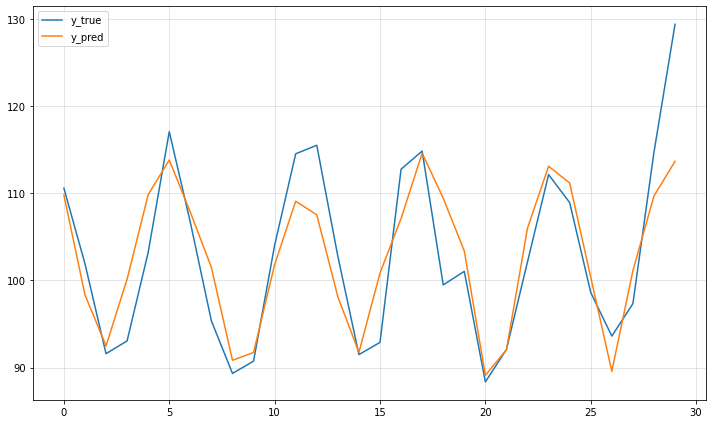

In [5]:
a = plot2d(y_test, y_pred_mof, labels=['y_true', 'y_pred'], figsize=(10, 6), eval_slices='[-1]')

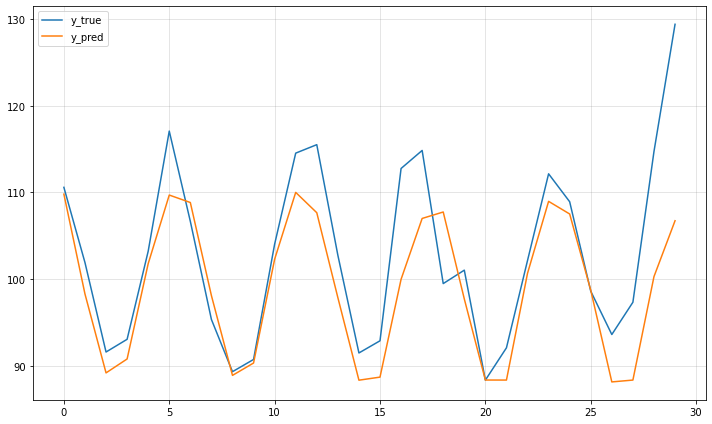

In [6]:
a = plot2d(y_test, y_pred_msf, labels=['y_true', 'y_pred'], figsize=(10, 6), eval_slices='[-1]')

# Pipeline

In [4]:
from spinesTS.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])

In [9]:
multi_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)

In [10]:
y_pred = multi_reg.predict(x_test)

In [11]:
r2_score(y_test.T, y_pred.T)

0.8068726243223835

## other algorithm pipeline

In [12]:
from spinesTS.data import LoadSupermarketIncoming
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

In [13]:
# Supermarket Incoming data
incoming = LoadSupermarketIncoming()
ds = incoming.dataset['goods_cnt']
x_train, x_test, y_train, y_test = split_series(ds, ds, 30, 30, train_size=0.8)

In [14]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")

r2: -0.28958570177112675
mae: 6517.684353784755
mape: 0.218168258752024


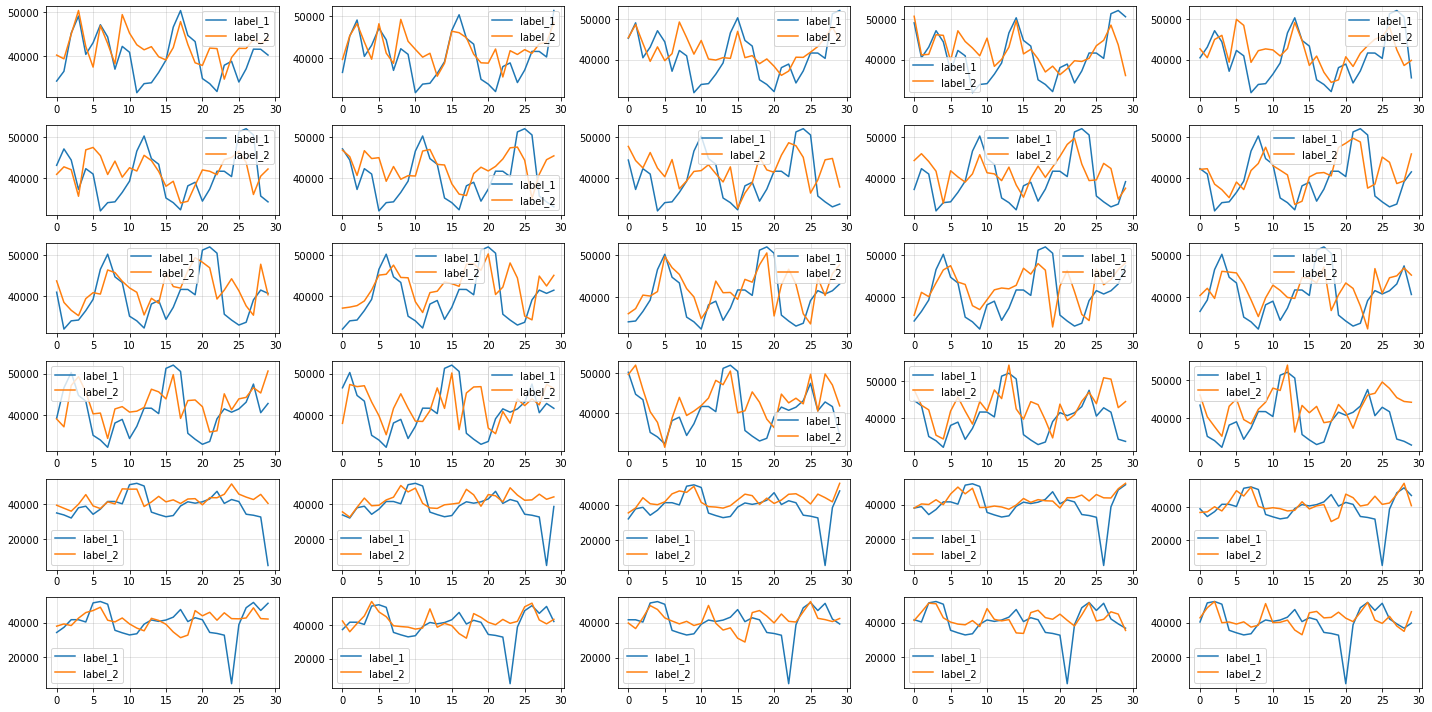

In [15]:
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

## feature extract

r2: -0.0015177136926835654
mae: 5742.441538567161
mape: 0.19654817147383893


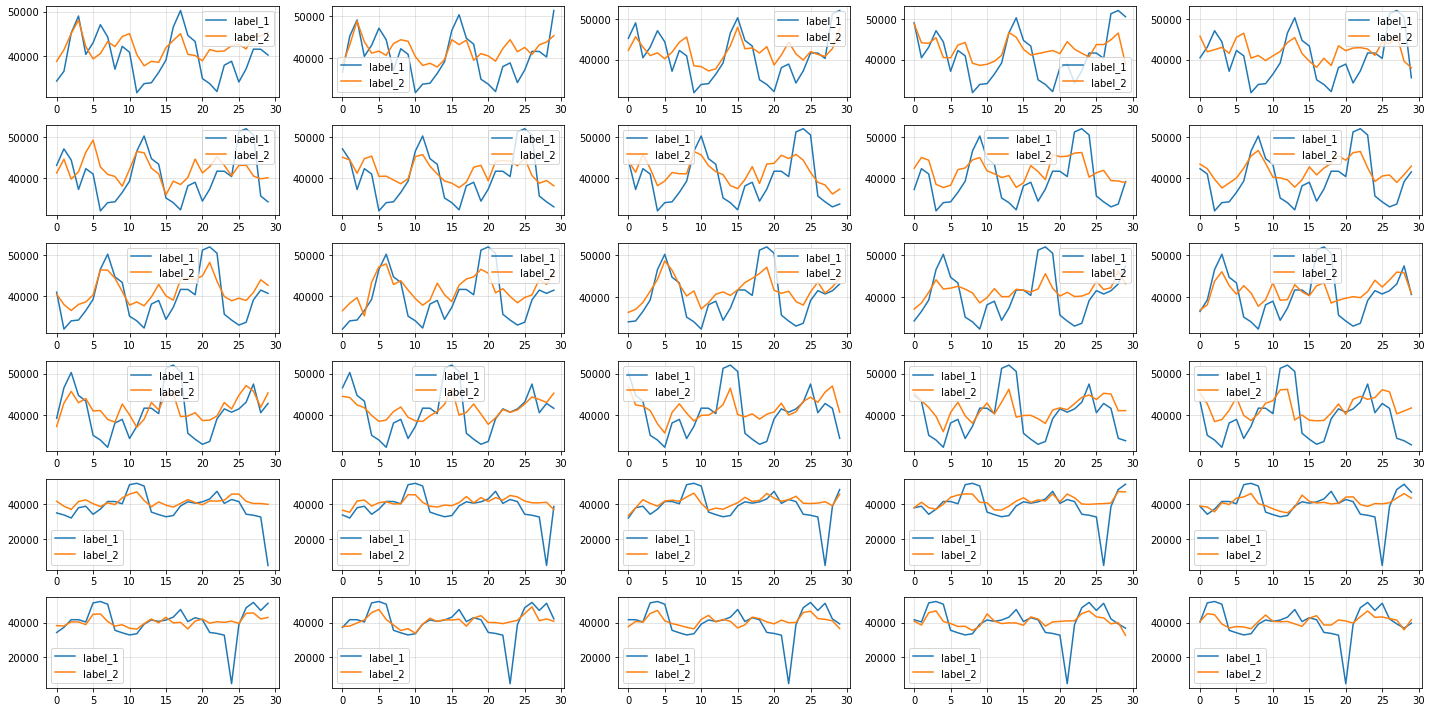

In [16]:
from spinesTS.features_extractor import FeatureExtractor
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', FeatureExtractor()),
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

In [3]:
from spinesTS.data import BuiltInSeriesData

series_data = BuiltInSeriesData(print_file_list=False)
cs = series_data[0]
cs_data = cs.dataset
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

x_train, x_test, y_train, y_test = split_series(cs_data['OT'], cs_data['OT'], 128, 24, train_size=0.9)

x_train = mms.fit_transform(x_train, MinMaxScaler)
x_test = mms.transform(x_test)
x_train.shape, x_test.shape

((15542, 128), (1727, 128))

r2: -1.9146795609588596
mae: 1.225884713505955
mape: 0.14208172445999864


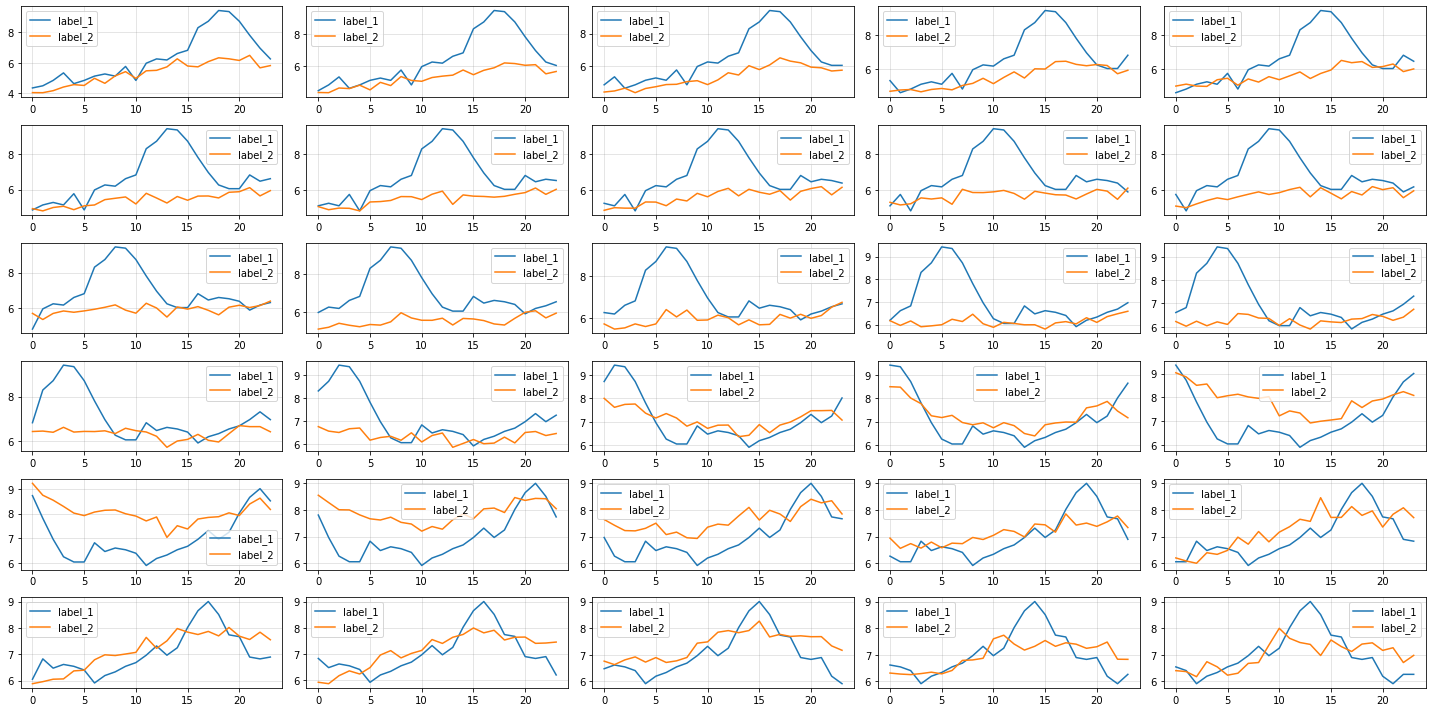

In [6]:
from spinesTS.metrics import *
# from spinesTS.features_extractor import FeatureExtractor
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    # ('fe', FeatureExtractor()),
    # ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')

r2: -2.15861580609891
mae: 1.2435495504031038
mape: 0.14395916165069475


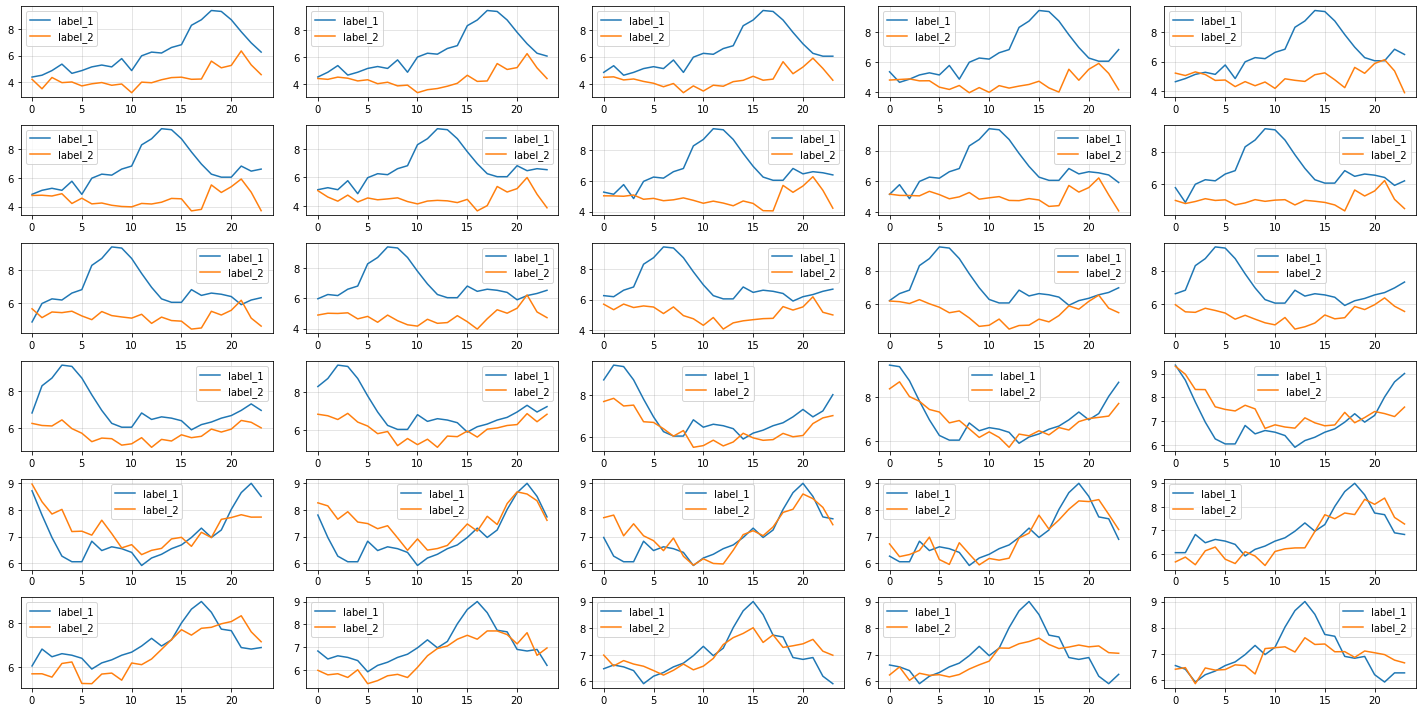

In [7]:
from spinesTS.metrics import *
from spinesTS.features_extractor import FeatureExtractor
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', FeatureExtractor()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
a = plot2d(y_test, y_pred, figsize=(20, 10), eval_slices='[:30]')